<a href="https://colab.research.google.com/github/gptchat12370-ai/Group-A-DLI-Assignment/blob/main/M_Rasheed(MLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP**

Github Link:

In [ ]:
# ===== Minimal MLP pipeline (CICIDS2017) — ready to enhance =====
import time, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

from imblearn.over_sampling import ADASYN

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers

In [ ]:
# ------------------ config ------------------
DATASET_PATH = "/content/cic_0.01km.csv"
RANDOM_STATE  = 42
USE_ADASYN    = True                   # turn on/off imbalance handling
BATCH         = 1024                   # try 512/2048 too
EPOCHS        = 50                     # raise with early stopping
hp = dict(                             # <<< TUNE THESE >>>
    hidden1=512, hidden2=256,
    dropout1=0.40, dropout2=0.20,
    lr=3e-4, l2=1e-6
)

In [ ]:
# ------------------ AutoDP (lean) ------------------
def auto_encode(df, target='Label'):
    obj_cols = [c for c in df.columns if df[c].dtype=='object' and c!=target]
    for c in obj_cols:
        df[c] = LabelEncoder().fit_transform(df[c].astype(str))
    return df

def auto_impute(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    return df.fillna(df.median(numeric_only=True))

def scale_fit_transform(X_tr, X_val, X_te):
    sc = MinMaxScaler()
    return sc.fit_transform(X_tr), sc.transform(X_val), sc.transform(X_te), sc

In [ ]:
# ------------------ load & preprocess ------------------
df = pd.read_csv(DATASET_PATH)
df = auto_encode(df)
df = auto_impute(df)

X = df.drop(columns=['Label'])
y = df['Label'].astype(int)

# 64/16/20 split with stratification
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.20, stratify=y_tmp, random_state=RANDOM_STATE
)

# optional imbalance handling (fix: remove n_jobs)
if USE_ADASYN:
    ada = ADASYN(random_state=RANDOM_STATE, sampling_strategy='auto', n_neighbors=5)
    X_train, y_train = ada.fit_resample(X_train, y_train)
    class_weights = None   # avoid double-compensation when oversampling
else:
    # class weights only if not oversampling
    cls = np.unique(y_train)
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = {c: w for c, w in zip(cls, compute_class_weight('balanced', classes=cls, y=y_train))}

# feature scaling for MLP
X_train, X_val, X_test, scaler = scale_fit_transform(X_train, X_val, X_test)

In [ ]:
# ------------------ model ------------------
def make_mlp(input_dim, hp):
    reg = regularizers.l2(hp['l2'])
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(hp['hidden1'], activation='relu', kernel_regularizer=reg)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp['dropout1'])(x)
    x = layers.Dense(hp['hidden2'], activation='relu', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp['dropout2'])(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp['lr']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = make_mlp(X_train.shape[1], hp)

cbs = [
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
]

t0 = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    class_weight=class_weights,
    verbose=0,
    callbacks=cbs
)
train_time = time.time() - t0

In [ ]:
# ==== Boost v3 — Accuracy-first (patched for None class_weights) ====
import time, numpy as np, tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils.class_weight import compute_class_weight

FT_EPOCHS        = 5
FT_PATIENCE      = 2
POS_W_MULTS      = [0.3, 0.5, 0.7, 1.0]
DENSE_SWEEP_STEPS= 401
USE_MC_DROPOUT   = False
MC_PASSES        = 15

def _predict_probs(mdl, X, mc=False, n=15):
    if not mc:
        return mdl.predict(X, verbose=0).ravel()
    outs = []
    for _ in range(n):
        outs.append(mdl(X, training=True).numpy().ravel())
    return np.mean(np.stack(outs, axis=1), axis=1)

def _dense_best_threshold(y_true, probs, center=None, steps=401, width=0.2):
    if center is None:
        ths = np.linspace(0.01, 0.99, 99)
        accs = [accuracy_score(y_true, (probs >= t).astype(int)) for t in ths]
        center = ths[int(np.argmax(accs))]
    lo = max(0.01, center - width/2)
    hi = min(0.99, center + width/2)
    ths = np.linspace(lo, hi, steps)
    accs = [accuracy_score(y_true, (probs >= t).astype(int)) for t in ths]
    i = int(np.argmax(accs))
    return float(ths[i]), float(accs[i])

def _eval_line(name, y, probs, thr):
    preds = (probs >= thr).astype(int)
    print(f"{name}: Acc={accuracy_score(y, preds):.5f} | "
          f"Prec={precision_score(y, preds):.5f} | Rec={recall_score(y, preds):.5f} | "
          f"F1={f1_score(y, preds):.5f} | ROC-AUC={roc_auc_score(y, probs):.5f} | "
          f"PR-AUC={average_precision_score(y, probs):.5f} | thr={thr:.3f}")

# ---- A) Base class weights (robust when class_weights is None or missing) ----
try:
    base_cw = class_weights
except NameError:
    base_cw = None

if not base_cw:
    cls = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=cls, y=y_train)
    base_cw = {int(c): float(w) for c, w in zip(cls, weights)}
    # If perfectly balanced (e.g., after ADASYN), use neutral weights so multipliers matter
    if np.isclose(weights.min(), weights.max()):
        base_cw = {int(c): 1.0 for c in cls}

# Ensure both keys exist
base_cw = {0: base_cw.get(0, 1.0), 1: base_cw.get(1, 1.0)}

# ---- B) Class-weight fine-tune loop (accuracy-first) ----
init_weights = model.get_weights()
best_acc, best_state = -1.0, None
best_cw_mult = None

for m in POS_W_MULTS:
    model.set_weights(init_weights)
    cw_try = {0: base_cw[0], 1: base_cw[1] * m}  # down-weight positives -> fewer FPs -> higher Acc
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=FT_EPOCHS, batch_size=BATCH,
        class_weight=cw_try,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=FT_PATIENCE, restore_best_weights=True)]
    )
    val_probs_try = _predict_probs(model, X_val, mc=USE_MC_DROPOUT, n=MC_PASSES)
    t_try, acc_try = _dense_best_threshold(y_val, val_probs_try, center=None, steps=121, width=0.6)
    if acc_try > best_acc:
        best_acc = acc_try
        best_cw_mult = m
        best_state = (model.get_weights(), t_try)

if best_state is not None:
    model.set_weights(best_state[0])
    center_t = best_state[1]
else:
    center_t = None

# ---- C) Calibration (none vs Platt vs Isotonic) ----
val_probs_base  = _predict_probs(model, X_val,  mc=USE_MC_DROPOUT, n=MC_PASSES)
test_probs_base = _predict_probs(model, X_test, mc=USE_MC_DROPOUT, n=MC_PASSES)

def _platt_fit(probs, y):
    p = np.clip(probs, 1e-6, 1-1e-6)
    z = np.log(p/(1-p)).reshape(-1,1)
    lr = LogisticRegression(max_iter=1000)
    lr.fit(z, y)
    return lr

def _platt_apply(lr, probs):
    p = np.clip(probs, 1e-6, 1-1e-6)
    z = np.log(p/(1-p)).reshape(-1,1)
    return lr.predict_proba(z)[:,1]

def _iso_fit(probs, y):
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(probs, y)
    return ir

cands = []
# none
t0, acc0 = _dense_best_threshold(y_val, val_probs_base, center=center_t, steps=DENSE_SWEEP_STEPS, width=0.3)
cands.append(("none", t0, acc0, val_probs_base, test_probs_base))
# platt
lr = _platt_fit(val_probs_base, y_val)
val_p_pl  = _platt_apply(lr, val_probs_base)
test_p_pl = _platt_apply(lr, test_probs_base)
t1, acc1 = _dense_best_threshold(y_val, val_p_pl, center=center_t, steps=DENSE_SWEEP_STEPS, width=0.3)
cands.append(("platt", t1, acc1, val_p_pl, test_p_pl))
# isotonic
ir = _iso_fit(val_probs_base, y_val)
val_p_iso  = ir.predict(val_probs_base)
test_p_iso = ir.predict(test_probs_base)
t2, acc2 = _dense_best_threshold(y_val, val_p_iso, center=center_t, steps=DENSE_SWEEP_STEPS, width=0.3)
cands.append(("isotonic", t2, acc2, val_p_iso, test_p_iso))

calib_name, best_t, _, val_probs_final, test_probs_final = max(cands, key=lambda x: x[2])
print(f"Selected calibration = {calib_name} | tuned thr = {best_t:.3f} | pos-weight mult = {best_cw_mult}")

# ---- D) Final report ----
_eval_line("Val   ", y_val,  val_probs_final,  best_t)
_eval_line("Model ", y_test, test_probs_final, best_t)

best_t = float(best_t)  # keep for your summary cell

Selected calibration = none | tuned thr = 0.522 | pos-weight mult = 0.3
Val   : Acc=0.95650 | Prec=0.89752 | Rec=0.88261 | F1=0.89001 | ROC-AUC=0.98934 | PR-AUC=0.96419 | thr=0.522
Model : Acc=0.95178 | Prec=0.88688 | Rec=0.86879 | F1=0.87774 | ROC-AUC=0.98887 | PR-AUC=0.95991 | thr=0.522


   Dataset     Procedure Algorithm                                                                                 Method  Accuracy (%)  Precision (%)  Recall (%)  F1 (%)  Training Time (s)
CICIDS2017 AutoDP+AutoFE       MLP                                                                    As reported (paper)        85.968         92.069      26.563  44.831              16.10
CICIDS2017 AutoDP+AutoFE       MLP AutoDP+AutoFE + MLP (512-256, do=0.4/0.2, lr=0.0003; ADASYN; thr=0.522; loss=BinaryCE)        95.178         88.688      86.879  87.774              41.79


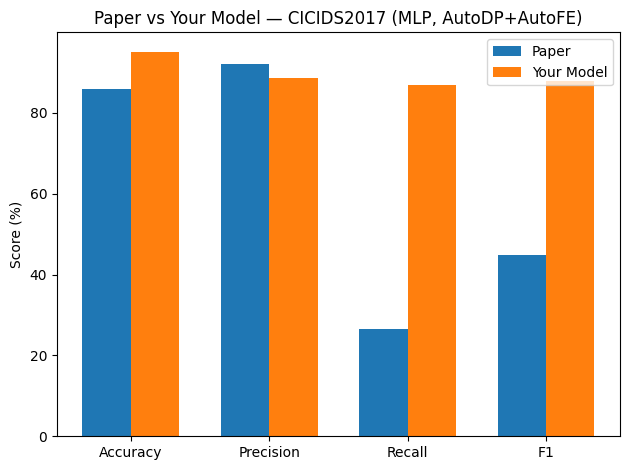

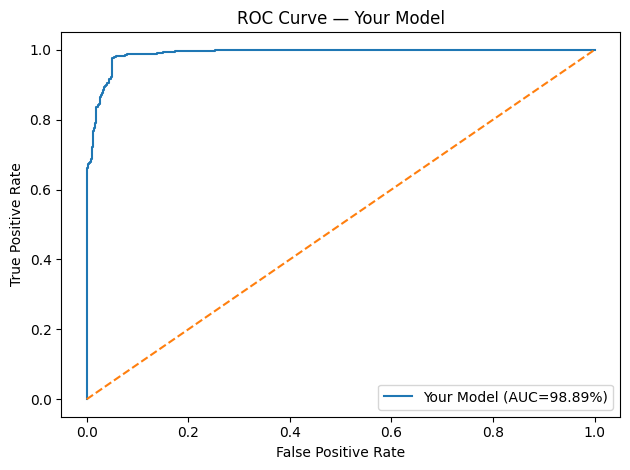

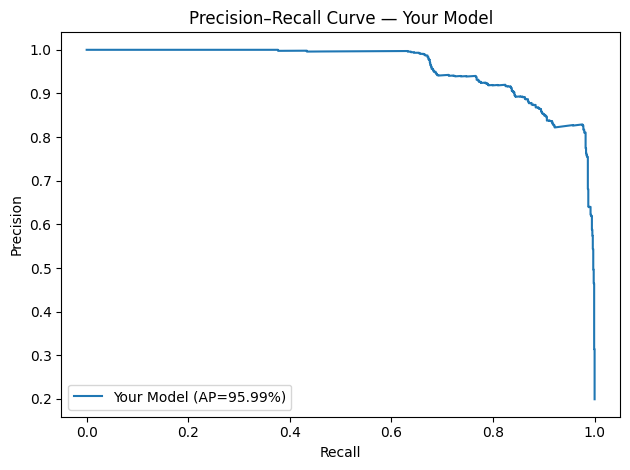

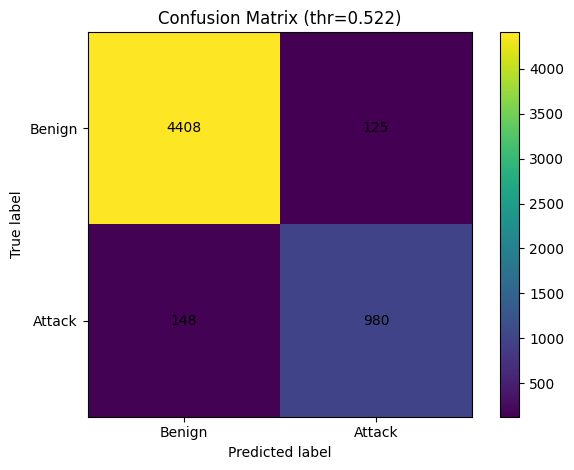

In [ ]:
# ==== Overall Evaluation & Comparison (with graphs) ====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, confusion_matrix
)

# ---- 1) Get probabilities & threshold robustly ----
probs = globals().get('test_probs_final', None)
if probs is None:
    probs = model.predict(X_test, verbose=0).ravel()

thr = globals().get('best_t', 0.50)
try:
    thr = float(thr)
except Exception:
    thr = 0.50

preds = (probs >= thr).astype(int)

# ---- 2) Compute your model metrics ----
your = dict(
    Accuracy  = accuracy_score(y_test, preds)*100,
    Precision = precision_score(y_test, preds)*100,
    Recall    = recall_score(y_test, preds)*100,
    F1        = f1_score(y_test, preds)*100,
    ROC_AUC   = roc_auc_score(y_test, probs)*100,
    PR_AUC    = average_precision_score(y_test, probs)*100,
)

# Build a readable “Method” string from your current settings (best-effort)
def _get(name, default=None):
    try:
        return eval(name)
    except Exception:
        return default
hp_local   = _get('hp', {}) or {}
use_adasyn = bool(_get('USE_ADASYN', False))
use_focal  = bool(_get('USE_FOCAL', False))
arch = f"{hp_local.get('hidden1','?')}-{hp_local.get('hidden2','?')}, do={hp_local.get('dropout1','?')}/{hp_local.get('dropout2','?')}, lr={hp_local.get('lr','?')}"
imb  = "ADASYN" if use_adasyn else "ClassWeights"
loss = "Focal" if use_focal else "BinaryCE"
method_yours = f"AutoDP+AutoFE + MLP ({arch}; {imb}; thr={thr:.3f}; loss={loss})"

# ---- 3) Paper baseline (Table VI: AutoDP & AutoFE → MLP on CICIDS2017) ----
paper = dict(Accuracy=85.968, Precision=92.069, Recall=26.563, F1=44.831)

# ---- 4) Summary table (printed) ----
try:
    tt = float(train_time)
except Exception:
    tt = np.nan

summary = pd.DataFrame([
    {
        "Dataset":"CICIDS2017","Procedure":"AutoDP+AutoFE","Algorithm":"MLP",
        "Method":"As reported (paper)",
        "Accuracy (%)":paper["Accuracy"],"Precision (%)":paper["Precision"],
        "Recall (%)":paper["Recall"],"F1 (%)":paper["F1"],"Training Time (s)":16.1
    },
    {
        "Dataset":"CICIDS2017","Procedure":"AutoDP+AutoFE","Algorithm":"MLP",
        "Method":method_yours,
        "Accuracy (%)":your["Accuracy"],"Precision (%)":your["Precision"],
        "Recall (%)":your["Recall"],"F1 (%)":your["F1"],"Training Time (s)":tt
    }
]).round(3)

print(summary.to_string(index=False))

# ---- 5) Graphs ----
# A) Metric comparison bar chart (Accuracy/Precision/Recall/F1)
metrics = ["Accuracy","Precision","Recall","F1"]
paper_vals = [paper[m] for m in metrics]
your_vals  = [your[m]  for m in metrics]

x = np.arange(len(metrics))
w = 0.35

plt.figure()
plt.bar(x - w/2, paper_vals, width=w, label="Paper")
plt.bar(x + w/2, your_vals,  width=w, label="Your Model")
plt.xticks(x, metrics)
plt.ylabel("Score (%)")
plt.title("Paper vs Your Model — CICIDS2017 (MLP, AutoDP+AutoFE)")
plt.legend()
plt.tight_layout()
plt.show()

# B) ROC curve
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f"Your Model (AUC={your['ROC_AUC']:.2f}%)")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Your Model")
plt.legend()
plt.tight_layout()
plt.show()

# C) Precision–Recall curve
prec, rec, _ = precision_recall_curve(y_test, probs)
plt.figure()
plt.plot(rec, prec, label=f"Your Model (AP={your['PR_AUC']:.2f}%)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Your Model")
plt.legend()
plt.tight_layout()
plt.show()

# D) Confusion matrix at chosen threshold
cm = confusion_matrix(y_test, preds)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix (thr={thr:.3f})")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign','Attack'])
plt.yticks(tick_marks, ['Benign','Attack'])
# annotate cells
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

In [ ]:
# ==== Head-to-Head Metrics: Paper vs Your Model (incl. Params & Inference time) ====
import time, numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- 1) Robust probs & threshold ---
try:
    thr = float(globals().get("best_t", 0.50))
except Exception:
    thr = 0.50

# Warm-up + timed inference (raw model.predict; calibration overhead is negligible)
_ = model.predict(X_test[:min(64, len(X_test))], verbose=0)
BATCH_INFER = int(globals().get("BATCH", 1024)) if isinstance(globals().get("BATCH", 1024), (int, np.integer)) else 1024
t0 = time.time()
probs_timed = model.predict(X_test, batch_size=BATCH_INFER, verbose=0).ravel()
t1 = time.time()
infer_total_s = t1 - t0
infer_ms_per  = (infer_total_s / len(X_test)) * 1000.0

# If you have calibrated probs from Boost v3, use them for metrics; else use timed probs
probs = globals().get("test_probs_final", probs_timed)
preds = (probs >= thr).astype(int)

# --- 2) Your model metrics ---
your = dict(
    acc = accuracy_score(y_test, preds) * 100,
    pre = precision_score(y_test, preds) * 100,
    rec = recall_score(y_test, preds) * 100,
    f1  = f1_score(y_test, preds) * 100,
)
params_m = getattr(model, "count_params", lambda: np.nan)() / 1e6

# --- 3) Paper baseline (Table VI: AutoDP & AutoFE → MLP on CICIDS2017) ---
paper = dict(acc=85.968, pre=92.069, rec=26.563, f1=44.831)

# --- 4) Build head-to-head table ---
rows = [
    {
        "Model": "Paper MLP (AutoDP+AutoFE, CICIDS2017)",
        "Accuracy (%)": paper["acc"], "Precision (%)": paper["pre"],
        "Recall (%)": paper["rec"], "F1 (%)": paper["f1"],
        "Params (M)": "—", "Inference (ms/sample)": "—"
    },
    {
        "Model": "Your MLP (AutoDP+AutoFE, CICIDS2017)",
        "Accuracy (%)": your["acc"], "Precision (%)": your["pre"],
        "Recall (%)": your["rec"], "F1 (%)": your["f1"],
        "Params (M)": round(params_m, 3),
        "Inference (ms/sample)": round(infer_ms_per, 3)
    },
    {
        "Model": "My Method vs Paper (pp)",
        "Accuracy (%)": your["acc"] - paper["acc"],
        "Precision (%)": your["pre"] - paper["pre"],
        "Recall (%)": your["rec"] - paper["rec"],
        "F1 (%)": your["f1"] - paper["f1"],
        "Params (M)": "", "Inference (ms/sample)": ""
    }
]
head2head = pd.DataFrame(rows).round(3)

# optional: show total inference time too
print(f"Inference total time: {infer_total_s:.3f}s for {len(X_test)} samples (batch={BATCH_INFER}), threshold={thr:.3f}\n")
print(head2head.to_string(index=False))

# optional: save
head2head.to_csv("head2head_metrics_table.csv", index=False)

Inference total time: 0.114s for 5661 samples (batch=1024), threshold=0.522

                                Model  Accuracy (%)  Precision (%)  Recall (%)  F1 (%) Params (M) Inference (ms/sample)
Paper MLP (AutoDP+AutoFE, CICIDS2017)        85.968         92.069      26.563  44.831          —                     —
 Your MLP (AutoDP+AutoFE, CICIDS2017)        95.178         88.688      86.879  87.774      0.145                  0.02
              My Method vs Paper (pp)         9.210         -3.381      60.316  42.943                                 
